Problem statement

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

Load libraries

In [237]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Load train and test files

In [238]:
#read files
#Reading train file:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/water_train.csv')
#Reading labels
labels = pd.read_csv('/content/drive/My Drive/Colab Notebooks/water_labels.csv')
#Reading test file:
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/water_test.csv')
#Reading sample submission file:
sample = pd.read_csv('/content/drive/My Drive/Colab Notebooks/water_sample.csv')

In [239]:
train

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,Pangani,Kiduruni,Kilimanjaro,3,5,Hai,Masama Magharibi,125,True,GeoData Consultants Ltd,Water Board,Losaa Kia water supply,True,1999,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,Rufiji,Igumbilo,Iringa,11,4,Njombe,Ikondo,56,True,GeoData Consultants Ltd,VWC,Ikondo electrical water sch,True,1996,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,Rufiji,Mwinyi,Dodoma,1,4,Chamwino,Mvumi Makulu,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


In [240]:
labels

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional
...,...,...
59395,60739,functional
59396,27263,functional
59397,37057,functional
59398,31282,functional


In [241]:
test

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,39307,0.0,2011-02-24,Danida,34,Da,38.852669,-6.582841,Kwambwezi,0,Wami / Ruvu,Yombo,Pwani,6,1,Bagamoyo,Yombo,20,True,GeoData Consultants Ltd,VWC,Bagamoyo wate,True,1988,mono,mono,motorpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
14846,18990,1000.0,2011-03-21,Hiap,0,HIAP,37.451633,-5.350428,Bonde La Mkondoa,0,Pangani,Mkondoa,Tanga,4,7,Kilindi,Mvungwe,2960,True,GeoData Consultants Ltd,VWC,NaN,False,1994,nira/tanira,nira/tanira,handpump,vwc,user-group,pay annually,annually,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
14847,28749,0.0,2013-03-04,NaN,1476,NaN,34.739804,-4.585587,Bwawani,0,Internal,Juhudi,Singida,13,2,Singida Rural,Ughandi,200,True,GeoData Consultants Ltd,VWC,NaN,NaN,2010,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,dam,dam,surface,communal standpipe,communal standpipe
14848,33492,0.0,2013-02-18,Germany,998,DWE,35.432732,-10.584159,Kwa John,0,Lake Nyasa,Namakinga B,Ruvuma,10,2,Songea Rural,Maposeni,150,True,GeoData Consultants Ltd,VWC,Mradi wa maji wa maposeni,True,2009,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe


In [242]:
sample

,id,status_group
0,50785,predicted label
1,51630,predicted label
2,17168,predicted label
3,45559,predicted label
4,49871,predicted label
...,...,...
14845,39307,predicted label
14846,18990,predicted label
14847,28749,predicted label
14848,33492,predicted label


Merge train and label

In [243]:
train = train.merge(labels, on='id', how='right')
train.head(5)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


Check for missing values

In [244]:
train.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [245]:
test.isnull().sum()

id                          0
amount_tsh                  0
date_recorded               0
funder                    869
gps_height                  0
installer                 877
longitude                   0
latitude                    0
wpt_name                    0
num_private                 0
basin                       0
subvillage                 99
region                      0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting            821
recorded_by                 0
scheme_management         969
scheme_name              7092
permit                    737
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity  

Impute missing values

In [246]:
#replace columns with mode
for column in train.columns:
    train[column].fillna(train[column].mode()[0], inplace=True)

for column in test.columns:
    test[column].fillna(test[column].mode()[0], inplace=True)

In [247]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0)

Convert date to number and only use year

In [248]:
train.date_recorded = train['date_recorded'].str.replace("-","")
train.date_recorded = train.date_recorded.str[:4]
train.date_recorded = train.date_recorded.astype(int)

test.date_recorded = test['date_recorded'].str.replace("-","")
test.date_recorded = test.date_recorded.str[:4]
test.date_recorded = test.date_recorded.astype(int)

train.date_recorded

0        2011
1        2013
2        2013
3        2013
4        2011
         ... 
59395    2013
59396    2011
59397    2011
59398    2011
59399    2011
Name: date_recorded, Length: 59400, dtype: int64

Analyse label

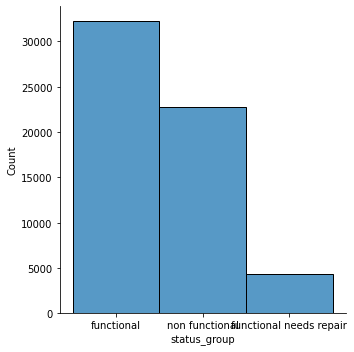

In [249]:
sns.displot(train['status_group'])

In [250]:
from collections import Counter

print(Counter(train.status_group))

Counter({'functional': 32259, 'non functional': 22824, 'functional needs repair': 4317})


In [251]:
train.status_group.value_counts(normalize=True) * 100

functional                 54.308081
non functional             38.424242
functional needs repair     7.267677
Name: status_group, dtype: float64

Labelencode Label

In [252]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

train.status_group = le.fit_transform(train.status_group)
train.status_group

0        0
1        0
2        0
3        2
4        0
        ..
59395    0
59396    0
59397    0
59398    0
59399    0
Name: status_group, Length: 59400, dtype: int64

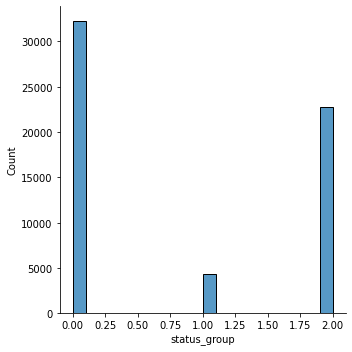

In [253]:
sns.displot(train['status_group'])

Ordinal Encode Independant Variables

In [254]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  int64  
 3   funder                 59400 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              59400 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59400 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [255]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

train.funder = enc.fit_transform(train.funder.values.reshape(-1,1))
train.installer = enc.fit_transform(train.installer.values.reshape(-1,1))
train.wpt_name = enc.fit_transform(train.wpt_name.values.reshape(-1,1))
train.basin = enc.fit_transform(train.basin.values.reshape(-1,1))
train.subvillage = enc.fit_transform(train.subvillage.values.reshape(-1,1))
train.region = enc.fit_transform(train.region.values.reshape(-1,1))
train.lga = enc.fit_transform(train.lga.values.reshape(-1,1))
train.ward = enc.fit_transform(train.ward.values.reshape(-1,1))
train.public_meeting = enc.fit_transform(train.public_meeting.values.reshape(-1,1))
train.recorded_by = enc.fit_transform(train.recorded_by.values.reshape(-1,1))
train.scheme_management = enc.fit_transform(train.scheme_management.values.reshape(-1,1))
train.scheme_name = enc.fit_transform(train.scheme_name.values.reshape(-1,1))
train.permit = enc.fit_transform(train.permit.values.reshape(-1,1))
train.extraction_type = enc.fit_transform(train.extraction_type.values.reshape(-1,1))
train.extraction_type_group = enc.fit_transform(train.extraction_type_group.values.reshape(-1,1))
train.extraction_type_class = enc.fit_transform(train.extraction_type_class.values.reshape(-1,1))
train.management = enc.fit_transform(train.management.values.reshape(-1,1))
train.management_group = enc.fit_transform(train.management_group.values.reshape(-1,1))
train.payment = enc.fit_transform(train.payment.values.reshape(-1,1))
train.payment_type = enc.fit_transform(train.payment_type.values.reshape(-1,1))
train.water_quality = enc.fit_transform(train.water_quality.values.reshape(-1,1))
train.quality_group = enc.fit_transform(train.quality_group.values.reshape(-1,1))
train.quantity = enc.fit_transform(train.quantity.values.reshape(-1,1))
train.quantity_group = enc.fit_transform(train.quantity_group.values.reshape(-1,1))
train.source = enc.fit_transform(train.source.values.reshape(-1,1))
train.source_type = enc.fit_transform(train.source_type.values.reshape(-1,1))
train.source_class = enc.fit_transform(train.source_class.values.reshape(-1,1))
train.waterpoint_type = enc.fit_transform(train.waterpoint_type.values.reshape(-1,1))
train.waterpoint_type_group = enc.fit_transform(train.waterpoint_type_group.values.reshape(-1,1))

test.funder = enc.fit_transform(test.funder.values.reshape(-1,1))
test.installer = enc.fit_transform(test.installer.values.reshape(-1,1))
test.wpt_name = enc.fit_transform(test.wpt_name.values.reshape(-1,1))
test.basin = enc.fit_transform(test.basin.values.reshape(-1,1))
test.subvillage = enc.fit_transform(test.subvillage.values.reshape(-1,1))
test.region = enc.fit_transform(test.region.values.reshape(-1,1))
test.lga = enc.fit_transform(test.lga.values.reshape(-1,1))
test.ward = enc.fit_transform(test.ward.values.reshape(-1,1))
test.public_meeting = enc.fit_transform(test.public_meeting.values.reshape(-1,1))
test.recorded_by = enc.fit_transform(test.recorded_by.values.reshape(-1,1))
test.scheme_management = enc.fit_transform(test.scheme_management.values.reshape(-1,1))
test.scheme_name = enc.fit_transform(test.scheme_name.values.reshape(-1,1))
test.permit = enc.fit_transform(test.permit.values.reshape(-1,1))
test.extraction_type = enc.fit_transform(test.extraction_type.values.reshape(-1,1))
test.extraction_type_group = enc.fit_transform(test.extraction_type_group.values.reshape(-1,1))
test.extraction_type_class = enc.fit_transform(test.extraction_type_class.values.reshape(-1,1))
test.management = enc.fit_transform(test.management.values.reshape(-1,1))
test.management_group = enc.fit_transform(test.management_group.values.reshape(-1,1))
test.payment = enc.fit_transform(test.payment.values.reshape(-1,1))
test.payment_type = enc.fit_transform(test.payment_type.values.reshape(-1,1))
test.water_quality = enc.fit_transform(test.water_quality.values.reshape(-1,1))
test.quality_group = enc.fit_transform(test.quality_group.values.reshape(-1,1))
test.quantity = enc.fit_transform(test.quantity.values.reshape(-1,1))
test.quantity_group = enc.fit_transform(test.quantity_group.values.reshape(-1,1))
test.source = enc.fit_transform(test.source.values.reshape(-1,1))
test.source_type = enc.fit_transform(test.source_type.values.reshape(-1,1))
test.source_class = enc.fit_transform(test.source_class.values.reshape(-1,1))
test.waterpoint_type = enc.fit_transform(test.waterpoint_type.values.reshape(-1,1))
test.waterpoint_type_group = enc.fit_transform(test.waterpoint_type_group.values.reshape(-1,1))

In [256]:
train

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011,1369.0,1390,1518.0,34.938093,-9.856322,37399.0,0,1.0,11807.0,3.0,11,5,51.0,1426.0,109,1.0,0.0,7.0,2245.0,0.0,1999,3.0,1.0,0.0,7.0,4.0,2.0,0.0,6.0,2.0,1.0,1.0,8.0,6.0,0.0,1.0,1.0,0
1,8776,0.0,2013,469.0,1399,545.0,34.698766,-2.147466,37195.0,0,4.0,15838.0,9.0,20,2,103.0,1576.0,280,1.0,0.0,2.0,598.0,1.0,2010,3.0,1.0,0.0,11.0,4.0,0.0,2.0,6.0,2.0,2.0,2.0,5.0,3.0,1.0,1.0,1.0,0
2,34310,25.0,2013,825.0,686,2048.0,37.460664,-3.821329,14572.0,0,5.0,9074.0,8.0,21,4,108.0,1624.0,250,1.0,0.0,7.0,2121.0,1.0,2009,3.0,1.0,0.0,7.0,4.0,4.0,5.0,6.0,2.0,1.0,1.0,0.0,1.0,1.0,2.0,1.0,0
3,67743,0.0,2013,1741.0,263,1852.0,38.486161,-11.155298,37285.0,0,7.0,8982.0,12.0,90,63,87.0,1571.0,58,1.0,0.0,7.0,598.0,1.0,1986,14.0,10.0,5.0,7.0,4.0,0.0,2.0,6.0,2.0,0.0,0.0,3.0,0.0,0.0,2.0,1.0,2
4,19728,0.0,2011,20.0,0,119.0,31.130847,-1.825359,35529.0,0,4.0,7698.0,4.0,18,1,26.0,1687.0,0,1.0,0.0,7.0,598.0,1.0,0,3.0,1.0,0.0,1.0,1.0,0.0,2.0,6.0,2.0,3.0,3.0,5.0,3.0,1.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013,436.0,1210,201.0,37.169807,-3.253847,513.0,0,5.0,5681.0,6.0,3,5,16.0,1090.0,125,1.0,0.0,10.0,1068.0,1.0,1999,3.0,1.0,0.0,9.0,4.0,4.0,5.0,6.0,2.0,1.0,1.0,8.0,6.0,0.0,1.0,1.0,0
59396,27263,4700.0,2011,177.0,1212,265.0,35.249991,-9.070629,24074.0,0,6.0,2980.0,3.0,11,4,91.0,353.0,56,1.0,0.0,7.0,479.0,1.0,1996,3.0,1.0,0.0,7.0,4.0,2.0,0.0,6.0,2.0,1.0,1.0,6.0,4.0,1.0,1.0,1.0,0
59397,37057,0.0,2011,456.0,0,390.0,34.017087,-8.750434,27926.0,0,6.0,8784.0,10.0,12,7,59.0,177.0,0,1.0,0.0,7.0,598.0,0.0,0,15.0,11.0,1.0,7.0,4.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,0.0,0.0,4.0,3.0,0
59398,31282,0.0,2011,884.0,0,1213.0,35.861315,-6.378573,29693.0,0,6.0,14012.0,2.0,1,4,11.0,1449.0,0,1.0,0.0,7.0,598.0,1.0,0,8.0,5.0,1.0,7.0,4.0,0.0,2.0,6.0,2.0,2.0,2.0,7.0,5.0,0.0,4.0,3.0,0


In [257]:
test

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013,175.0,1996,214.0,35.290799,-4.059696,656.0,0,0.0,3916.0,8.0,21,3,63.0,17.0,321,1.0,0.0,2.0,395.0,1.0,2012,9.0,6.0,3.0,3.0,2.0,0.0,2.0,6.0,2.0,3.0,3.0,5.0,3.0,1.0,6.0,5.0
1,51630,0.0,2013,250.0,1569,221.0,36.656709,-3.309214,1780.0,0,5.0,2717.0,0.0,2,2,0.0,650.0,300,1.0,0.0,6.0,1610.0,1.0,2000,3.0,1.0,0.0,7.0,4.0,0.0,2.0,6.0,2.0,2.0,2.0,8.0,6.0,0.0,1.0,1.0
2,17168,0.0,2013,250.0,1567,221.0,34.767863,-5.004344,9673.0,0,0.0,5398.0,18.0,13,2,109.0,1677.0,500,1.0,0.0,6.0,1453.0,1.0,2010,9.0,6.0,3.0,7.0,4.0,0.0,2.0,6.0,2.0,2.0,2.0,5.0,3.0,1.0,6.0,5.0
3,45559,0.0,2013,222.0,267,262.0,38.058046,-9.418672,5595.0,0,7.0,2795.0,7.0,80,43,49.0,1192.0,250,1.0,0.0,6.0,395.0,1.0,1987,9.0,6.0,3.0,7.0,4.0,6.0,6.0,6.0,2.0,0.0,0.0,7.0,5.0,0.0,6.0,5.0
4,49871,500.0,2013,73.0,1260,75.0,35.006123,-10.950412,5706.0,0,7.0,3544.0,16.0,10,3,61.0,1075.0,60,1.0,0.0,9.0,76.0,1.0,2000,3.0,1.0,0.0,9.0,4.0,3.0,1.0,6.0,2.0,1.0,1.0,8.0,6.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,39307,0.0,2011,145.0,34,226.0,38.852669,-6.582841,7223.0,0,8.0,8402.0,14.0,6,1,3.0,1948.0,20,1.0,0.0,6.0,84.0,1.0,1988,7.0,4.0,2.0,7.0,4.0,0.0,2.0,6.0,2.0,1.0,1.0,6.0,4.0,1.0,1.0,1.0
14846,18990,1000.0,2011,286.0,0,319.0,37.451633,-5.350428,332.0,0,5.0,5028.0,20.0,4,7,33.0,1350.0,2960,1.0,0.0,6.0,395.0,0.0,1994,8.0,5.0,1.0,7.0,4.0,2.0,0.0,4.0,4.0,2.0,2.0,7.0,5.0,0.0,4.0,3.0
14847,28749,0.0,2013,250.0,1476,221.0,34.739804,-4.585587,457.0,0,0.0,1833.0,18.0,13,2,109.0,1868.0,200,1.0,0.0,6.0,395.0,1.0,2010,3.0,1.0,0.0,7.0,4.0,0.0,2.0,6.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0
14848,33492,0.0,2013,242.0,998,221.0,35.432732,-10.584159,3438.0,0,1.0,6246.0,16.0,10,2,111.0,998.0,150,1.0,0.0,6.0,1114.0,1.0,2009,3.0,1.0,0.0,7.0,4.0,0.0,2.0,6.0,2.0,2.0,2.0,6.0,4.0,1.0,1.0,1.0


Graphically represent independent variables

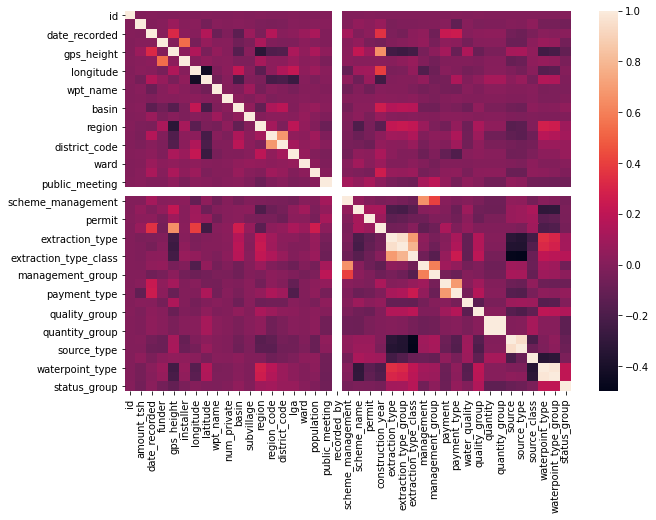

In [258]:
#create a heatmap to correlate promotion
plt.figure(figsize=(10,7))
cmap=train.corr()
sns.heatmap(cmap)

Define X, y and X_test

In [259]:
y = train["status_group"]
X = train.drop(['id', 'status_group'], axis=1)
X_test = test.drop(['id'], axis=1)

Split train set for training and validation

In [260]:
#split training set for training and testing
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0, test_size=0.10, stratify=y, shuffle=True)
#check shapes of testing data
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((53460, 39), (5940, 39), (53460,), (5940,))

Scaler

In [261]:
# Import `StandardScaler` from `sklearn.preprocessing`
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Define the scaler 
scaler = StandardScaler().fit(X_train)
# Scale the train set
X_train = scaler.transform(X_train)
# Scale the validation set
X_val = scaler.transform(X_val)
# Scale the test set
X_test = scaler.transform(X_test)

Class weights

In [262]:
from sklearn.utils import class_weight

class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight('balanced',np.unique(y_train), y_train)))

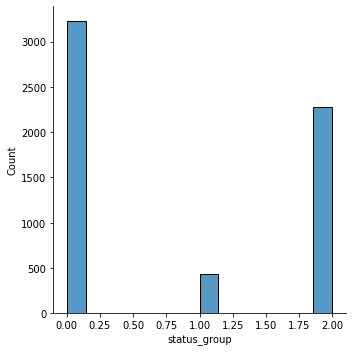

In [263]:
sns.displot(y_val)

In [264]:
print(Counter(y_val))

Counter({0: 3226, 2: 2282, 1: 432})


In [265]:
y_val.value_counts(normalize=True) * 100

0    54.309764
2    38.417508
1     7.272727
Name: status_group, dtype: float64

Build model

ADABoostClassifier

In [266]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

model = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=2000, random_state=1, class_weight=class_weights)).fit(X_train, y_train)
print(model.score(X_train, y_train))

1.0


XGB Classifier

In [267]:
from xgboost import XGBClassifier

#model = XGBClassifier(learning_rate=0.01, n_estimators=2000, max_depth=5, min_child_weight=10, 
   #                   gamma=0.4,nthread=4, subsample=0.8, colsample_bytree=0.8, objective='multi:softmax',scale_pos_weight=3,seed=29, 
   #                   class_weight=class_weights).fit(X_train, y_train)
#print(model.score(X_train, y_train))

HistGradientBoostingClassifier

In [268]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier  

#model = HistGradientBoostingClassifier(loss='categorical_crossentropy',max_iter=2000).fit(X_train, y_train)
#print(model.score(X_train, y_train))

MLPClassifier

In [269]:
from sklearn.neural_network import MLPClassifier

#model = MLPClassifier(max_iter=2000, random_state=1, learning_rate='adaptive').fit(X_train, y_train)
#print(model.score(X_train, y_train))

CatBoostClassifier

In [270]:
!pip install catboost
from catboost import CatBoostClassifier

#model = CatBoostClassifier(random_state=1, class_weights=class_weights).fit(X_train, y_train)
#print(model.score(X_train, y_train))

Predict on validation set

In [271]:
# Make predictions on validation dataset
model = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=2000, random_state=1, class_weight=class_weights)).fit(X_train, y_train)
print(model.score(X_val, y_val))

0.8178451178451178


In [272]:
y_pred = model.predict(X_val)

In [273]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_val, y_pred, normalize=False))

4858


In [274]:
print(Counter(y_pred))

Counter({0: 3579, 2: 2098, 1: 263})


In [275]:
y_pred.sum()/len(y_pred)*100

75.06734006734007

In [276]:
#Create a confusion matrix
from sklearn.metrics import confusion_matrix

#y_test as first argument and the preds as second argument 
confusion_matrix(y_val, y_pred)

array([[2908,   73,  245],
       [ 229,  150,   53],
       [ 442,   40, 1800]])

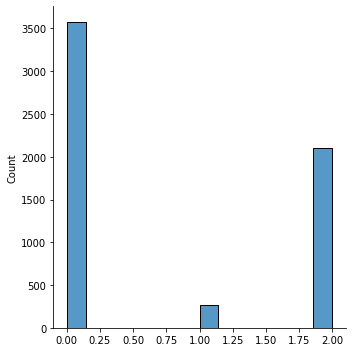

In [277]:
sns.displot(y_pred)

Predict on test set

In [278]:
prediction = model.predict(X_test)
prediction

array([2, 0, 0, ..., 0, 0, 2])

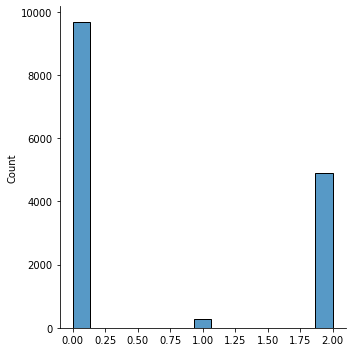

In [279]:
sns.displot(prediction)

In [280]:
print(Counter(prediction))

Counter({0: 9691, 2: 4892, 1: 267})


In [281]:
prediction.sum()/len(prediction)*100

67.68350168350167

Reverse label encoding

In [282]:
prediction = le.inverse_transform(prediction)
prediction

array(['non functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

Prepare submission

In [283]:
output = pd.DataFrame({'id': test.id, 'status_group': prediction})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [284]:
#upload submission
my_submission = pd.read_csv("my_submission.csv")
my_submission

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14845,39307,non functional
14846,18990,functional
14847,28749,functional
14848,33492,functional
